## 스파크 기본설정

In [2]:
import os
import sys

#home=os.path.expanduser("~") # HOME이 설정되어 있지 않으면 expanduser('~')를 사용한다.
#osn.environ["PYSPARK_PYTHON"] = "/usr/bin/python"
os.environ["SPARK_HOME"]=os.path.join(os.path.expanduser("~"),r"C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7")
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [3]:
import pyspark
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config("spark.sql.warehouse.dir", r"C:\Users\user\MyStudySpace\2019-2\BigData_Spark\src")\
    .getOrCreate()

## vector

### Dense veotors

In [3]:
import numpy as np

dv= np.array([1.0, 2.1, 3])

In [4]:
type(dv)

numpy.ndarray

In [5]:
from pyspark.mllib.linalg import Vectors

dv1mllib=Vectors.dense([1.0, 2.1, 3])
print dv1mllib, type(dv1mllib)

[1.0,2.1,3.0] <class 'pyspark.mllib.linalg.DenseVector'>


In [6]:
from pyspark.ml.linalg import Vectors

dv1ml = Vectors.dense([1.0, 2.1, 3])
print dv1ml

[1.0,2.1,3.0]


**product, dot, norm**과 같은 벡터 연산을 할 수도 있다. 결과 값은 numpy와 동일

In [7]:
print dv1ml.dot(dv1ml)

14.41


In [8]:
np.dot(dv,dv)

14.41

In [9]:
print dv1ml*dv1ml

[1.0,4.41,9.0]


### Sparse vecotors

In [10]:
sv1 = Vectors.sparse(3, [1, 2], [1.0, 3.0])
print sv1.toArray()

[0. 1. 3.]


In [7]:
import numpy as np
import scipy.sparse as sps

row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
mtx = sps.csc_matrix((data, (row, col)), shape=(3, 3))
print mtx.todense()

[[1 0 2]
 [0 0 3]
 [4 5 6]]


In [4]:
from pyspark.mllib.linalg import Matrix, Matrices
dm = Matrices.dense(6,4,[1, 2, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 5, 6, 7, 0, 0, 0, 0, 0, 0, 8])
dm.toArray()

array([[1., 0., 0., 0.],
       [2., 3., 0., 0.],
       [0., 0., 5., 0.],
       [0., 4., 6., 0.],
       [0., 0., 7., 0.],
       [0., 0., 0., 8.]])

### RowMatrix

In [12]:
p = [[1.0,2.0,3.0],[1.1,2.1,3.1],[1.2,2.2,3.3]]
my=spark.sparkContext.parallelize(p)

my.collect()

[[1.0, 2.0, 3.0], [1.1, 2.1, 3.1], [1.2, 2.2, 3.3]]

RowMatrix는 pyspark.mllib.linalg.distributed에서 제공되는 분산벡터

In [13]:
from pyspark.mllib.linalg.distributed import RowMatrix
rm=RowMatrix(my)

In [14]:
print type(rm)

<class 'pyspark.mllib.linalg.distributed.RowMatrix'>


In [15]:
rm.rows.collect()

[DenseVector([1.0, 2.0, 3.0]),
 DenseVector([1.1, 2.1, 3.1]),
 DenseVector([1.2, 2.2, 3.3])]

## Labeled Point

분류 및 회귀분석에 사용되는 데이터 타잎
- 형태 : [Label,[f1,f2,......,fn]]  // label, features로 구성
    - [f1,f2,......,fn] : 학습 데이터
    - 학습한 후에는 Label 제거
    

In [5]:
from pyspark.mllib.regression import LabeledPoint

print LabeledPoint(1.0, [1.0, 2.0, 3.0])

(1.0,[1.0,2.0,3.0])


In [17]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

print LabeledPoint(1992, Vectors.sparse(10, {0: 3.0, 1:5.5, 2: 10.0}))

(1992.0,(10,[0,1,2],[3.0,5.5,10.0]))


서로 다른 패키지의 데이터타잎 mllib LabeledPoint와 ml Vectors를 혼용하면, 형변환 오류가 발생
- fromML(ml벡터)사용하여 mllib 입력받는 labeledpoint에 사용가능

In [18]:
from pyspark.mllib.regression import LabeledPoint

LabeledPoint(1.0, dv1mllib)

LabeledPoint(1.0, [1.0,2.1,3.0])

In [19]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

LabeledPoint(1.0, Vectors.fromML(dv1ml))

LabeledPoint(1.0, [1.0,2.1,3.0])

### DataFrame에서 Labeled Point
- Python list에서 DataFrame 생성

In [20]:
p = [[1,[1.0,2.0,3.0]],[1,[1.1,2.1,3.1]],[0,[1.2,2.2,3.3]]]
trainDf=spark.createDataFrame(p)
trainDf.collect()

[Row(_1=1, _2=[1.0, 2.0, 3.0]),
 Row(_1=1, _2=[1.1, 2.1, 3.1]),
 Row(_1=0, _2=[1.2, 2.2, 3.3])]

In [21]:
from pyspark.mllib.regression import LabeledPoint
p = [LabeledPoint(1,[1.0,2.0,3.0]),
     LabeledPoint(1,[1.1,2.1,3.1]),
     LabeledPoint(0,[1.2,2.2,3.3])]
trainDf=spark.createDataFrame(p)
trainDf.collect()

[Row(features=DenseVector([1.0, 2.0, 3.0]), label=1.0),
 Row(features=DenseVector([1.1, 2.1, 3.1]), label=1.0),
 Row(features=DenseVector([1.2, 2.2, 3.3]), label=0.0)]

schema를 사용해서 DataFrame을 생성
- 'label'은 DoubleType
- 'features'는 VectorType

In [22]:
from pyspark.mllib.linalg import SparseVector, VectorUDT
from pyspark.sql.types import StructType, StructField, DoubleType
_rdd = spark.sparkContext.parallelize([
    (0.0, SparseVector(4, {1: 1.0, 3: 5.5})),
    (1.0, SparseVector(4, {0: -1.0, 2: 0.5}))])

schema = StructType([
    StructField("label", DoubleType(), True),
    StructField("features", VectorUDT(), True)
])

In [23]:
trainDf=_rdd.toDF(schema)
trainDf.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



### sparse에서 dense vector로 변환

In [24]:
from pyspark.sql.functions import udf
#from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.mllib.linalg import DenseVector, VectorUDT
#myudf=udf(lambda x: Vectors.dense(x), VectorUDT())
#myudf=udf(lambda x: Vectors.dense(x))
myudf=udf(lambda x: DenseVector(x.toArray()), VectorUDT())
_trainDf2=trainDf.withColumn('dvf',myudf(trainDf.features))

In [25]:
_trainDf2.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- dvf: vector (nullable = true)



In [26]:
_trainDf2.show()

+-----+--------------------+------------------+
|label|            features|               dvf|
+-----+--------------------+------------------+
|  0.0| (4,[1,3],[1.0,5.5])| [0.0,1.0,0.0,5.5]|
|  1.0|(4,[0,2],[-1.0,0.5])|[-1.0,0.0,0.5,0.0]|
+-----+--------------------+------------------+



## maxtrix

In [27]:
from pyspark.mllib.linalg import Matrix, Matrices

# Create a dense matrix ((1.0, 2.0), (3.0, 4.0), (5.0, 6.0))
dm = Matrices.dense(3, 2, [1, 2, 3, 4, 5, 6])

# Create a sparse matrix ((9.0, 0.0), (0.0, 8.0), (0.0, 6.0))
sm = Matrices.sparse(3, 2, [0, 1, 3], [0, 2, 1], [9, 6, 8])

## libsvm format
- svm을 처리하기 위한 데이터 형식

In [28]:
fsvm=os.path.join(os.environ["SPARK_HOME"],'data','mllib','sample_libsvm_data.txt')
dfsvm = spark.read.format("libsvm").load(fsvm)

In [29]:
type(dfsvm)

pyspark.sql.dataframe.DataFrame

## DataFrame 변환
- Pipeline은 여러 Estimator를 묶은 Estimator를 반환
- Estimator.fit() :모델의 인자를 설정, 데이터에 적용한다. Transformer를 반환
- Transformer.transform() : 열을 선택, 변환한다. 그 결과를 DataFrame으로 반환

### 모델의 입력데이터로 변환
- 특징을 추출하여 feature vectors를 구성한다.
- 분류를 하는 경우에는 class 또는 label 값이 필요하다.
- 텍스트는 'bag of words'으로 표현한다.
    - 문서는 단어로 구성이 되며,
    - 단어의 순서는 의미를 가지지 않는다.
    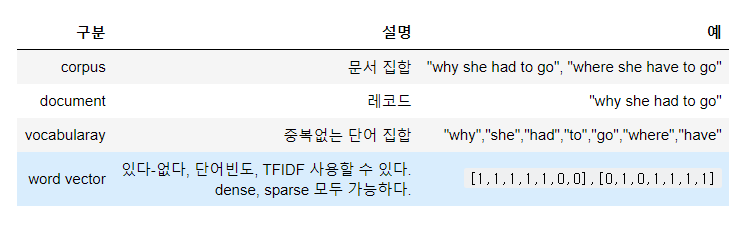

### Python을 사용한 단어 빈도 계산

In [2]:
# Let it be lyrics
doc=[
    "When I find myself in times of trouble",
    "Mother Mary comes to me",
    "Speaking words of wisdom, let it be",
    "And in my hour of darkness",
    "She is standing right in front of me",
    "Speaking words of wisdom, let it be",
    "Let it be",
    "Let it be",
    "Let it be",
    "Let it be",
    "Whisper words of wisdom, let it be"
]

In [3]:
d={}
for sentence in doc:
    words=sentence.split()
    for word in words:
        if word in d:
            d[word]+=1
        else:
            d[word]=1

In [5]:
# Python 2 - 3 compatible code
# for k,v in d.items():
# 딕셔너리는 iterator 필요함
for k,v in d.iteritems():
    print k,v

right 1
be 7
is 1
When 1
it 7
in 3
Mary 1
Speaking 2
standing 1
darkness 1
find 1
wisdom, 3
to 1
Let 4
And 1
I 1
let 3
She 1
words 3
Mother 1
front 1
trouble 1
me 2
myself 1
hour 1
of 6
times 1
Whisper 1
my 1
comes 1


### scikit-learn TF-IDF
- TfidfTransformer는 TF-IDF(Term Frequency-Inverse Document Frequency)를 계산한다.
    - 1: Tokenizer로 문장을 단어로 분리
    - 2: CountVectorizer를 사용하여 단어의 빈도수tf를 계산
    - 3: HashingTF를 사용하여 'word vector'를 계산
    - 4: IDF를 계산
    - 5: TF-IDF를 계산

### TF-IDF 계산

In [7]:
import math
tf=1./4
df=3.
N=11.
idf=math.log((N+1)/(df+1))+1
print idf

2.09861228867


**sklearn을 사용한 TF-IDF**

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
vectorizer = CountVectorizer()

문서와 단어 별로 표 가능

In [10]:
print vectorizer.fit_transform(doc).todense()

[[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
 [1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1]]


In [11]:
print vectorizer.vocabulary_

{u'and': 0, u'be': 1, u'right': 17, u'whisper': 25, u'is': 8, u'it': 9, u'wisdom': 26, u'me': 12, u'let': 10, u'words': 27, u'in': 7, u'front': 5, u'trouble': 23, u'find': 4, u'standing': 20, u'comes': 2, u'myself': 15, u'darkness': 3, u'hour': 6, u'of': 16, u'when': 24, u'times': 21, u'to': 22, u'she': 18, u'mother': 13, u'my': 14, u'mary': 11, u'speaking': 19}


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english',norm = None)

In [13]:
print vectorizer.fit_transform(doc)

  (0, 9)	2.791759469228055
  (0, 10)	2.791759469228055
  (1, 5)	2.791759469228055
  (1, 4)	2.791759469228055
  (1, 0)	2.791759469228055
  (2, 7)	2.386294361119891
  (2, 13)	2.09861228866811
  (2, 12)	2.09861228866811
  (2, 3)	1.4054651081081644
  (3, 2)	2.791759469228055
  (3, 1)	2.791759469228055
  (4, 8)	2.791759469228055
  (4, 6)	2.791759469228055
  (5, 7)	2.386294361119891
  (5, 13)	2.09861228866811
  (5, 12)	2.09861228866811
  (5, 3)	1.4054651081081644
  (6, 3)	1.4054651081081644
  (7, 3)	1.4054651081081644
  (8, 3)	1.4054651081081644
  (9, 3)	1.4054651081081644
  (10, 13)	2.09861228866811
  (10, 12)	2.09861228866811
  (10, 3)	1.4054651081081644
  (10, 11)	2.791759469228055


In [14]:
print vectorizer.vocabulary_

{u'standing': 8, u'right': 6, u'darkness': 1, u'hour': 2, u'whisper': 11, u'times': 9, u'let': 3, u'speaking': 7, u'words': 13, u'mother': 5, u'trouble': 10, u'wisdom': 12, u'mary': 4, u'comes': 0}


In [15]:
print vectorizer.idf_

[2.79175947 2.79175947 2.79175947 1.40546511 2.79175947 2.79175947
 2.79175947 2.38629436 2.79175947 2.79175947 2.79175947 2.79175947
 2.09861229 2.09861229]


doc를 list of list로 만들어, DataFrame을 생성

In [19]:
doc=[
    ["When I find myself in times of trouble"],
    ["Mother Mary comes to me"],
    ["Speaking words of wisdom, let it be"],
    ["And in my hour of darkness"],
    ["She is standing right in front of me"],
    ["Speaking words of wisdom, let it be"],
    [u"우리 Let it be"],
    [u"나 Let it be"],
    [u"너 Let it be"],
    ["Let it be"],
    ["Whisper words of wisdom, let it be"]
]

myDf=spark.createDataFrame(doc,['sent'])
myDf.show(truncate=False)

+--------------------------------------+
|sent                                  |
+--------------------------------------+
|When I find myself in times of trouble|
|Mother Mary comes to me               |
|Speaking words of wisdom, let it be   |
|And in my hour of darkness            |
|She is standing right in front of me  |
|Speaking words of wisdom, let it be   |
|우리 Let it be                          |
|나 Let it be                           |
|너 Let it be                           |
|Let it be                             |
|Whisper words of wisdom, let it be    |
+--------------------------------------+



## StringIndexer
- 문자를 인덱스 값, double로 변환
    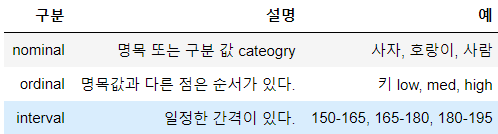

In [8]:
from pyspark.ml.feature import StringIndexer
labelIndexer = StringIndexer(inputCol="sent", outputCol="sentLabel")
model=labelIndexer.fit(myDf)
siDf=model.transform(myDf)
siDf.show()

NameError: name 'myDf' is not defined

### Tokenizer
- 문장을 단어와 같은 token으로 분리
- 단어는 배열로 구성, 요소는 string

In [21]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="sent", outputCol="words")
tokDf = tokenizer.transform(myDf)
for r in tokDf.select("sent", "words").take(3):
    print r

Row(sent=u'When I find myself in times of trouble', words=[u'when', u'i', u'find', u'myself', u'in', u'times', u'of', u'trouble'])
Row(sent=u'Mother Mary comes to me', words=[u'mother', u'mary', u'comes', u'to', u'me'])
Row(sent=u'Speaking words of wisdom, let it be', words=[u'speaking', u'words', u'of', u'wisdom,', u'let', u'it', u'be'])


### RegTokenizer
- 단어를 분리하기 위한 패턴 적용 가능
- whitespace \s 패턴을 적용

In [22]:
from pyspark.ml.feature import RegexTokenizer
re = RegexTokenizer(inputCol="sent", outputCol="wordsReg", pattern="\\s+")
reDf=re.transform(myDf)
reDf.show()

+--------------------+--------------------+
|                sent|            wordsReg|
+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|
|Mother Mary comes...|[mother, mary, co...|
|Speaking words of...|[speaking, words,...|
|And in my hour of...|[and, in, my, hou...|
|She is standing r...|[she, is, standin...|
|Speaking words of...|[speaking, words,...|
|        우리 Let it be|   [우리, let, it, be]|
|         나 Let it be|    [나, let, it, be]|
|         너 Let it be|    [너, let, it, be]|
|           Let it be|       [let, it, be]|
|Whisper words of ...|[whisper, words, ...|
+--------------------+--------------------+



### stopwords

In [23]:
from pyspark.ml.feature import StopWordsRemover
stop = StopWordsRemover(inputCol="wordsReg", outputCol="nostops")

현재 stop words에 자신의 것을 추가해서, 재설정

In [24]:
stopwords=list()
_stopwords=stop.getStopWords()
for e in _stopwords:
    stopwords.append(e)

_mystopwords=[u"나",u"너", u"우리"]
for e in _mystopwords:
    stopwords.append(e)
stop.setStopWords(stopwords)

StopWordsRemover_4151b572092692b1d33d

In [25]:
for e in stop.getStopWords():
    print e,

i me my myself we our ours ourselves you your yours yourself yourselves he him his himself she her hers herself it its itself they them their theirs themselves what which who whom this that these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don should now d ll m o re ve y ain aren couldn didn doesn hadn hasn haven isn ma mightn mustn needn shan shouldn wasn weren won wouldn 나 너 우리


In [27]:
stopDf=stop.transform(reDf)
stopDf.show(truncate=False)

+--------------------------------------+-----------------------------------------------+-------------------------------+
|sent                                  |wordsReg                                       |nostops                        |
+--------------------------------------+-----------------------------------------------+-------------------------------+
|When I find myself in times of trouble|[when, i, find, myself, in, times, of, trouble]|[find, times, trouble]         |
|Mother Mary comes to me               |[mother, mary, comes, to, me]                  |[mother, mary, comes]          |
|Speaking words of wisdom, let it be   |[speaking, words, of, wisdom,, let, it, be]    |[speaking, words, wisdom,, let]|
|And in my hour of darkness            |[and, in, my, hour, of, darkness]              |[hour, darkness]               |
|She is standing right in front of me  |[she, is, standing, right, in, front, of, me]  |[standing, right, front]       |
|Speaking words of wisdom, let i

### CountVectorizer
- 입력: a collection of text documents
- 출력: word vector (sparse) vocabulary x TF
- tokenize하고 나서 사용

In [28]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="nostops", outputCol="cv",
    vocabSize=30,minDF=1.0)
cvModel = cv.fit(stopDf)
cvDf = cvModel.transform(stopDf)

cvDf.collect()
cvDf.select('sent','nostops','cv').show()
for v in cvModel.vocabulary:
    print v,

+--------------------+--------------------+--------------------+
|                sent|             nostops|                  cv|
+--------------------+--------------------+--------------------+
|When I find mysel...|[find, times, tro...|(16,[5,6,8],[1.0,...|
|Mother Mary comes...|[mother, mary, co...|(16,[10,13,14],[1...|
|Speaking words of...|[speaking, words,...|(16,[0,1,2,3],[1....|
|And in my hour of...|    [hour, darkness]|(16,[7,9],[1.0,1.0])|
|She is standing r...|[standing, right,...|(16,[4,12,15],[1....|
|Speaking words of...|[speaking, words,...|(16,[0,1,2,3],[1....|
|        우리 Let it be|               [let]|      (16,[0],[1.0])|
|         나 Let it be|               [let]|      (16,[0],[1.0])|
|         너 Let it be|               [let]|      (16,[0],[1.0])|
|           Let it be|               [let]|      (16,[0],[1.0])|
|Whisper words of ...|[whisper, words, ...|(16,[0,1,2,11],[1...|
+--------------------+--------------------+--------------------+

let wisdom, words speaki

### TF-IDF

In [29]:
from pyspark.ml.feature import HashingTF, IDF

hashTF = HashingTF(inputCol="nostops", outputCol="hash", numFeatures=50)
hashDf = hashTF.transform(stopDf)
idf = IDF(inputCol="hash", outputCol="idf")
idfModel = idf.fit(hashDf)
idfDf = idfModel.transform(hashDf)
for e in idfDf.select("nostops","hash").take(10):
    print(e)

Row(nostops=[u'find', u'times', u'trouble'], hash=SparseVector(50, {10: 1.0, 24: 1.0, 43: 1.0}))
Row(nostops=[u'mother', u'mary', u'comes'], hash=SparseVector(50, {1: 1.0, 21: 1.0, 24: 1.0}))
Row(nostops=[u'speaking', u'words', u'wisdom,', u'let'], hash=SparseVector(50, {9: 1.0, 12: 1.0, 14: 1.0, 41: 1.0}))
Row(nostops=[u'hour', u'darkness'], hash=SparseVector(50, {23: 1.0, 27: 1.0}))
Row(nostops=[u'standing', u'right', u'front'], hash=SparseVector(50, {24: 1.0, 43: 1.0, 46: 1.0}))
Row(nostops=[u'speaking', u'words', u'wisdom,', u'let'], hash=SparseVector(50, {9: 1.0, 12: 1.0, 14: 1.0, 41: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))
Row(nostops=[u'let'], hash=SparseVector(50, {14: 1.0}))


### NGram
- unigram은 한 단어로, bigram은 두 단어로 구성한다.

In [32]:
from pyspark.ml.feature import NGram
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")
ngramDf = ngram.transform(tokDf)
ngramDf.show(truncate = False)
for e in ngramDf.select("words","ngrams").take(3):
    print e


+--------------------------------------+-----------------------------------------------+--------------------------------------------------------------------------+
|sent                                  |words                                          |ngrams                                                                    |
+--------------------------------------+-----------------------------------------------+--------------------------------------------------------------------------+
|When I find myself in times of trouble|[when, i, find, myself, in, times, of, trouble]|[when i, i find, find myself, myself in, in times, times of, of trouble]  |
|Mother Mary comes to me               |[mother, mary, comes, to, me]                  |[mother mary, mary comes, comes to, to me]                                |
|Speaking words of wisdom, let it be   |[speaking, words, of, wisdom,, let, it, be]    |[speaking words, words of, of wisdom,, wisdom, let, let it, it be]        |
|And in my hour 

### 연속데이터의 변환

In [24]:
%%writefile data/ds_spark_heightweight.txt
"Index", Height(Inches)", "Weight(Pounds)"
1, 65.78, 112.99
2, 71.52, 136.49
3, 69.40, 153.03
4, 68.22, 142.34
5, 67.79, 144.30
6, 68.70, 123.30
7, 69.80, 141.49
8, 70.01, 136.46
9, 67.90, 112.37
10, 66.78, 120.67
11, 66.49, 127.45
12, 67.62, 114.14
13, 68.30, 125.61
14, 67.12, 122.46
15, 68.28, 116.09
16, 71.09, 140.00
17, 66.46, 129.50
18, 68.65, 142.97
19, 71.23, 137.90
20, 67.13, 124.04
21, 67.83, 141.28
22, 68.88, 143.54
23, 63.48, 97.90
24, 68.42, 129.50
25, 67.63, 141.85
26, 67.21, 129.72
27, 70.84, 142.42
28, 67.49, 131.55
29, 66.53, 108.33
30, 65.44, 113.89
31, 69.52, 103.30
32, 65.81, 120.75
33, 67.82, 125.79
34, 70.60, 136.22
35, 71.80, 140.10
36, 69.21, 128.75
37, 66.80, 141.80
38, 67.66, 121.23
39, 67.81, 131.35
40, 64.05, 106.71
41, 68.57, 124.36
42, 65.18, 124.86
43, 69.66, 139.67
44, 67.97, 137.37
45, 65.98, 106.45
46, 68.67, 128.76
47, 66.88, 145.68
48, 67.70, 116.82
49, 69.82, 143.62
50, 69.09, 134.93
51, 69.91, 147.02
52, 67.33, 126.33
53, 70.27, 125.48
54, 69.10, 115.71
55, 65.38, 123.49
56, 70.18, 147.89
57, 70.41, 155.90
58, 66.54, 128.07
59, 66.36, 119.37
60, 67.54, 133.81
61, 66.50, 128.73
62, 69.00, 137.55
63, 68.30, 129.76
64, 67.01, 128.82
65, 70.81, 135.32
66, 68.22, 109.61
67, 69.06, 142.47
68, 67.73, 132.75
69, 67.22, 103.53
70, 67.37, 124.73
71, 65.27, 129.31
72, 70.84, 134.02
73, 69.92, 140.40
74, 64.29, 102.84
75, 68.25, 128.52
76, 66.36, 120.30
77, 68.36, 138.60
78, 65.48, 132.96
79, 69.72, 115.62
80, 67.73, 122.52
81, 68.64, 134.63
82, 66.78, 121.90
83, 70.05, 155.38
84, 66.28, 128.94
85, 69.20, 129.10
86, 69.13, 139.47
87, 67.36, 140.89
88, 70.09, 131.59
89, 70.18, 121.12
90, 68.23, 131.51
91, 68.13, 136.55
92, 70.24, 141.49
93, 71.49, 140.61
94, 69.20, 112.14
95, 70.06, 133.46
96, 70.56, 131.80
97, 66.29, 120.03
98, 63.43, 123.10
99, 66.77, 128.14
100, 68.89, 115.48
101, 64.87, 102.09
102, 67.09, 130.35
103, 68.35, 134.18
104, 65.61, 98.64
105, 67.76, 114.56
106, 68.02, 123.49
107, 67.66, 123.05
108, 66.31, 126.48
109, 69.44, 128.42
110, 63.84, 127.19
111, 67.72, 122.06
112, 70.05, 127.61
113, 70.19, 131.64
114, 65.95, 111.90
115, 70.01, 122.04
116, 68.61, 128.55
117, 68.81, 132.68
118, 69.76, 136.06
119, 65.46, 115.94
120, 68.83, 136.90
121, 65.80, 119.88
122, 67.21, 109.01
123, 69.42, 128.27
124, 68.94, 135.29
125, 67.94, 106.86
126, 65.63, 123.29
127, 66.50, 109.51
128, 67.93, 119.31
129, 68.89, 140.24
130, 70.24, 133.98
131, 68.27, 132.58
132, 71.23, 130.70
133, 69.10, 115.56
134, 64.40, 123.79
135, 71.10, 128.14
136, 68.22, 135.96
137, 65.92, 116.63
138, 67.44, 126.82
139, 73.90, 151.39
140, 69.98, 130.40
141, 69.52, 136.21
142, 65.18, 113.40
143, 68.01, 125.33
144, 68.34, 127.58
145, 65.18, 107.16
146, 68.26, 116.46
147, 68.57, 133.84
148, 64.50, 112.89
149, 68.71, 130.76
150, 68.89, 137.76
151, 69.54, 125.40
152, 67.40, 138.47
153, 66.48, 120.82
154, 66.01, 140.15
155, 72.44, 136.74
156, 64.13, 106.11
157, 70.98, 158.96
158, 67.50, 108.79
159, 72.02, 138.78
160, 65.31, 115.91
161, 67.08, 146.29
162, 64.39, 109.88
163, 69.37, 139.05
164, 68.38, 119.90
165, 65.31, 128.31
166, 67.14, 127.24
167, 68.39, 115.23
168, 66.29, 124.80
169, 67.19, 126.95
170, 65.99, 111.27
171, 69.43, 122.61
172, 67.97, 124.21
173, 67.76, 124.65
174, 65.28, 119.52
175, 73.83, 139.30
176, 66.81, 104.83
177, 66.89, 123.04
178, 65.74, 118.89
179, 65.98, 121.49
180, 66.58, 119.25
181, 67.11, 135.02
182, 65.87, 116.23
183, 66.78, 109.17
184, 68.74, 124.22
185, 66.23, 141.16
186, 65.96, 129.15
187, 68.58, 127.87
188, 66.59, 120.92
189, 66.97, 127.65
190, 68.08, 101.47
191, 70.19, 144.99
192, 65.52, 110.95
193, 67.46, 132.86
194, 67.41, 146.34
195, 69.66, 145.59
196, 65.80, 120.84
197, 66.11, 115.78
198, 68.24, 128.30
199, 68.02, 127.47
200, 71.39, 127.88 

Overwriting data/ds_spark_heightweight.txt


In [35]:
from pyspark.sql.types import *
rdd=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))

myRdd=rdd.map(lambda line:[float(x) for x in line.split('\t')])
myDf=spark.createDataFrame(myRdd)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 22.0 failed 1 times, most recent failure: Lost task 0.0 in stage 22.0 (TID 22, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 172, in main
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 167, in process
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\rdd.py", line 1306, in takeUpToNumLeft
  File "<ipython-input-35-9d30c7d01766>", line 4, in <lambda>
ValueError: could not convert string to float: "Index", Height(Inches)", "Weight(Pounds)"

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1450)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1438)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1437)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1437)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1659)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1618)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1607)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1871)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1884)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1897)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:441)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:128)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:211)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 172, in main
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 167, in process
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\Users\user\spark-2.0.0-bin-hadoop2.7\spark-2.0.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\rdd.py", line 1306, in takeUpToNumLeft
  File "<ipython-input-35-9d30c7d01766>", line 4, in <lambda>
ValueError: could not convert string to float: "Index", Height(Inches)", "Weight(Pounds)"

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [34]:
myDf.printSchema()

root
 |-- _1: string (nullable = true)

